In [1]:
use_quandl = True
try:
    import quandl
except:
    use_quandl = False
use_portfoliomgr = True
try:
    from Portfolio import Portfolio
except:
    use_portfoliomgr = False
import pandas as pd
import numpy as np
from scipy.optimize import minimize


In [2]:
from Robinhood import Robinhood
trader = Robinhood()
trader.login('hang2','zhhISbest2')

True

In [86]:

class GMTA:
    def __init__(
        self,
        scodes,
        Rf = 0.01/310,
        period = 150,
        no_short = True,
        optimizer_tol = 1e-15,
        optimizer_maxiter = 600,
        quandl_apikey = None,
    ):
        global use_quandl,use_portfoliomgr
        if not use_quandl:
            assert quandl_apikey is None
        self.scodes = scodes
        self.Rf = Rf
        self.period = period
        self.no_short = no_short
        self.tol = optimizer_tol
        self.maxiter = optimizer_maxiter
        self.data = pd.DataFrame(columns = scodes)
        self.gmv = None
        self.mve = None
        self.apikey = quandl_apikey
            
    def update(self,data=None):
        if data is not None:
            self.data = data
        self.cov = self.data.cov()
        self.std = self.data.std(ddof = 0)
        self.mean = self.data.mean()
        
    def global_variance(self,w):
        assert len(w) == len(self.scodes)
        res = np.dot(np.matmul(w,self.cov.values),w)
        return np.sqrt(res)
    
    def sharpe_ratio(self,w):
        assert len(w) == len(self.scodes)
        return (np.dot(w,self.mean.values)-self.Rf)/self.global_variance(w)
    
    def GMV(self,no_short = None,tol = None,maxiter = None):
        if no_short is None:
            no_short = self.no_short
        if tol is None:
            tol = self.tol
        if maxiter is None:
            maxiter = self.maxiter
        w0 = np.array([1.0/len(self.scodes)]*len(self.scodes))
        params = {
            'fun':lambda x:self.global_variance(x),
            'x0':w0,
            'method':'SLSQP',
            'constraints':{
                'type':'eq',
                'fun':(lambda x:sum(x)-1)
            },
            'tol':tol,
            'options':{
                'maxiter':maxiter
            }
        }
        if no_short:
            params['bounds'] = [(0,1) for i in range(len(self.scodes))]
        gmv = minimize(**params)
        if gmv.message != 'Optimization terminated successfully.':
            print("Error during GMV minimize:")
            print(gmv.message)
        self.Wgmv = gmv.x
        self.Rgmv = np.dot(gmv.x,self.mean)
        self.Vgmv = gmv.fun
        self.gmv = gmv
        
    def MVE(self,no_short = None,tol = None,maxiter = None):
        if no_short is None:
            no_short = self.no_short
        if tol is None:
            tol = self.tol
        if maxiter is None:
            maxiter = self.maxiter
        w0 = np.array([1.0/len(self.scodes)]*len(self.scodes))
        params = {
            'fun':lambda x:-self.sharpe_ratio(x),
            'x0':w0,
            'method':'SLSQP',
            'constraints':{
                'type':'eq',
                'fun':(lambda x:sum(x)-1)
            },
            'tol':tol,
            'options':{
                'maxiter':maxiter
            }
        }
        if no_short:
            params['bounds'] = [(0,1) for i in range(len(self.scodes))]
        mve = minimize(**params)
        if mve.message != 'Optimization terminated successfully.':
            print("Error during MVE minimize:")
            print(mve.message)
        self.Wmve = mve.x
        self.Rmve = np.dot(mve.x,self.mean)
        self.Vmve = self.global_variance(mve.x)
        self.mve = mve
        
    def GMc(self):
        wmve = self.Wmve.reshape(-1,1)
        wgmv = self.Wgmv.reshape(-1,1)
        U = np.matmul(wgmv,wmve.T)
        return np.dot(U.flatten(),self.cov.values.flatten())
    
    def risk_return(self,w=0.02):
        cov = self.GMc()
        r = w*self.Rgmv + (1-w)*self.Rmve
        d = np.sqrt(w**2*self.Vgmv**2 + (1-w)**2*self.Vmve**2 + 2*w*(1-w)*cov)
        return d,r

    def one_trade(self,data=None,w=0.02):
        if data is not None:
            data = data[self.scodes]
        self.data = data.iloc[-self.period:]
        self.update()
        self.GMV()
        self.MVE()
        return self.Wgmv * w + self.Wmve * (1-w)
        
    def trading_simulator(self,data,w=0.02):
        data = data[self.scodes]
        ws = [np.zeros(len(self.scodes))]
        rs = []
        assert len(data) > self.period
        for i in range(len(data)-self.period):
            self.data = data.iloc[i:i+self.period]
            self.update()
            self.GMV()
            self.MVE()
            rs.append(np.dot(ws[-1],self.data.iloc[-1].values))
            ws.append(w*self.Wgmv + (1-w)*self.Wmve)
        return rs,ws
    
    def quandl_test_data_generator(self):
        global use_quandl
        if self.apikey is None:
            print('quandl is not avaliable or no apikey provided, cannot use this function')
            return
        quandl.ApiConfig.api_key = self.apikey
        res = pd.DataFrame()
        for scode in self.scodes:
            cl = quandl.get("EOD/"+scode.replace(".","_"))['Close']
            res[scode] = (cl-cl.shift(1))/cl.shift(1)
        quandl.ApiConfig.api_key = None
        return res.dropna()
    
    def quandl_today_data_generator(self):
        global use_quandl
        if self.apikey is None:
            print('quandl is not avaliable or no apikey provided, cannot use this function')
            return
        res = pd.DataFrame()
        quandl.ApiConfig.api_key = self.apikey
        for scode in self.scodes:
            cl = quandl.get("EOD/"+scode.replace(".","_"),rows = self.period+1)["Close"]
            res[scode] = (cl-cl.shift(1))/cl.shift(1)
        quandl.ApiConfig.api_key = None
        return res.dropna()
    
    def one_trade_per_day_with_quandl_and_robinhood(
        self,
        pmgr,
        pnmae,
        args = {
            "call_from_mgr" : False
        },misc = {
            "w" : 0.02
        }
    ):
        assert isinstance(pmgr,PortfolioMgr)
        assert pname in PortfolioMgr.portfolios
        if not args["call_from_mgr"]:
            pmgr.schedule(
                algo = self,
                method = "one_trade_per_day_with_quandl_and_robinhood",
                portfolio_name = pname,
                freq = 1440
            )
        w = misc['w']
        p = pmgr.portfolios[pnmae]
        data = self.quandl_today_data_generator()
        p.portfolio_record_lock.acquire()
        idxs = p.portfolio_record.index
        p.portfolio_record_lock.release()
        for x in idxs:
            assert x in self.scodes
        w_target = self.one_trade(data)
        w_current = pd.Series(p.get_weights(*self.scodes)).loc[self.scodes].values
        w_diff = w_target - w_current
        s_diff = pd.Series(
            ((w_diff*p.get_market_value())//p.quote_last_price(*self.scodes)).astype(int),
            index = self.scodes
        )
        for scode in self.scodes:
            n = s_diff.loc[scode]
            if n>0:
                p.market_buy(scode,int(n))
            elif n<0:
                p.market_sell(scode,int(-n))
    
    def intraday_trading_with_robinhood(
        self,
        pmgr,
        pname,
        args = {
            "frequent" : 2,
            "call_from_mgr" : False
        },
        misc = {
            "w" : 0.02
        }
    ):
        assert isinstance(pmgr,PortfolioMgr)
        assert pname in pmgr.portfolios
        if not args["call_from_mgr"]:
            pmgr.schedule(
                algo = self,
                method = "intrday_trading_with_robinhood",
                portfolio_name = pname,
                freq = args["frequent"]
            )
        w = misc['w']
        p = pmgr.portfolios[pnmae]
        self.data.loc[p.get_time()] = p.quote_last_price(*self.scodes)
        if len(self.data)<self.period:
            return
        w_target = self.one_trade()
        w_current = pd.Series(p.get_weights(*self.scodes)).loc[self.scodes].values
        w_diff = w_target - w_current
        s_diff = pd.Series(
            ((w_diff*p.get_market_value())//self.data.loc[p.get_time()].values).astype(int),
            index = self.scodes
        )
        for scode in self.scodes:
            n = s_diff.loc[scode]
            if n>0:
                p.market_buy(scode,int(n))
            elif n<0:
                p.market_sell(scode,int(-n))

In [85]:
trader = Robinhood()
trader.login('hang2','zhhISbest2')
p = Portfolio(trader=trader,name="default",iniFund=500)
gmta = GMTA(['BABA','YRD','CMCSA','WLB'],quandl_apikey="rixaXs71r2KgkmPHW9jZ")

In [80]:
gmta.one_trade_per_day_with_quandl_and_robinhood(p)

In [83]:
24*60

1440

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

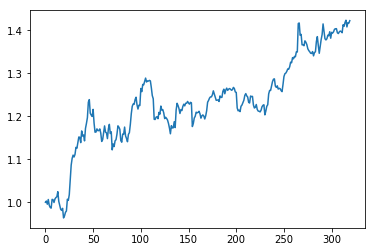

In [93]:
symbols = ["BAC","MMM","FFBC","YRD"]    #name of your asserts, you can add as many as you want to the list
n = 200                       #algorithm will calculate gmv,mve weights for last n days
Rf = 0.01/360                 #risk free rate(daily)
no_short = True               #forbid shorting strategy
w = 0.02                      #algorithm will keep on adjusting your portfolio to w*GMV + (1-w)*MVE

data = pd.DataFrame()
print()#I get data from the quandl api, you can use your own data source
for scode in symbols:
    cl = quandl.get("EOD/"+scode)["Close"]
    data[scode] = (cl-cl.shift(1))/cl.shift(1)  #calculate price change in each day
data = data.dropna()
gmta = GMTA(symbols,Rf=Rf,period=n,no_short=no_short)
rts,chs = gmta.trading_simulator(data,w)
rts = np.array(rts)+1
for i in range(1,len(rts)):
    rts[i] = rts[i]*rts[i-1]
plt.plot(rts)           #plot results of simulating

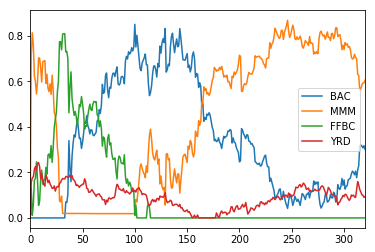

In [95]:
pd.DataFrame(chs,columns = ["BAC","MMM","FFBC","YRD"]).plot()

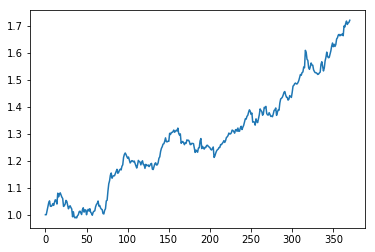

In [57]:
plt.plot(r)

In [34]:
x = a.robinhood_one_trade_a_day_with_quandl(p)

In [29]:
xx = p.quote_last_price(*a.scodes)

In [97]:
p.is_market_open()

False

In [20]:
use_quandl

True

In [88]:
quandl.ApiConfig.api_key = "rixaXs71r2KgkmPHW9jZ"

In [98]:
class A:
    def __init__(self):
        pass
    def a(self,x):
        return x
    def b(x):
        return x

In [99]:
a = A()

In [105]:
try:
    assert False
except AssertionError:
    print(1)

1


In [104]:
from time import sleep